In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn import mixture
from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import log_loss
import time
import itertools
import operator

In [3]:
os.listdir('dataset')

['data.csv', 'sample_submission.csv']

In [4]:
data = pd.read_csv('dataset/data.csv')
sample_submission = pd.read_csv('dataset/sample_submission.csv')

In [6]:
data = data[data['shot_made_flag'].notnull()].reset_index()

In [18]:
columns_of_data = data.columns
print(columns_of_data)
data['game_date_DT'] = pd.to_datetime(data['game_date'])
data['dayOfWeek'] = data['game_date_DT'].dt.dayofweek
data['dayOfYear'] = data['game_date_DT'].dt.dayofyear


Index(['index', 'action_type', 'combined_shot_type', 'game_event_id',
       'game_id', 'lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining',
       'period', 'playoffs', 'season', 'seconds_remaining', 'shot_distance',
       'shot_made_flag', 'shot_type', 'shot_zone_area', 'shot_zone_basic',
       'shot_zone_range', 'team_id', 'team_name', 'game_date', 'matchup',
       'opponent', 'shot_id', 'game_date_DT'],
      dtype='object')


In [20]:
data['secondsFromPeriodEnd']   = 60*data['minutes_remaining']+data['seconds_remaining']
data['secondsFromPeriodStart'] = 60*(11-data['minutes_remaining'])+(60-data['seconds_remaining'])

data['secondsFromGameStart']   = (data['period'] <= 4).astype(int)*(data['period']-1)*12*60 + (data['period'] > 4).astype(int)*((data['period']-4)*5*60 + 3*12*60) + data['secondsFromPeriodStart']


In [21]:
data.loc[:10,['period','minutes_remaining','seconds_remaining','secondsFromGameStart']]


,period,minutes_remaining,seconds_remaining,secondsFromGameStart
0,1,10,22,98
1,1,7,45,255
2,1,6,52,308
3,2,6,19,1061
4,3,9,32,1588
5,3,8,52,1628
6,3,6,12,1788
7,3,3,36,1944
8,3,1,56,2044
9,1,11,0,60


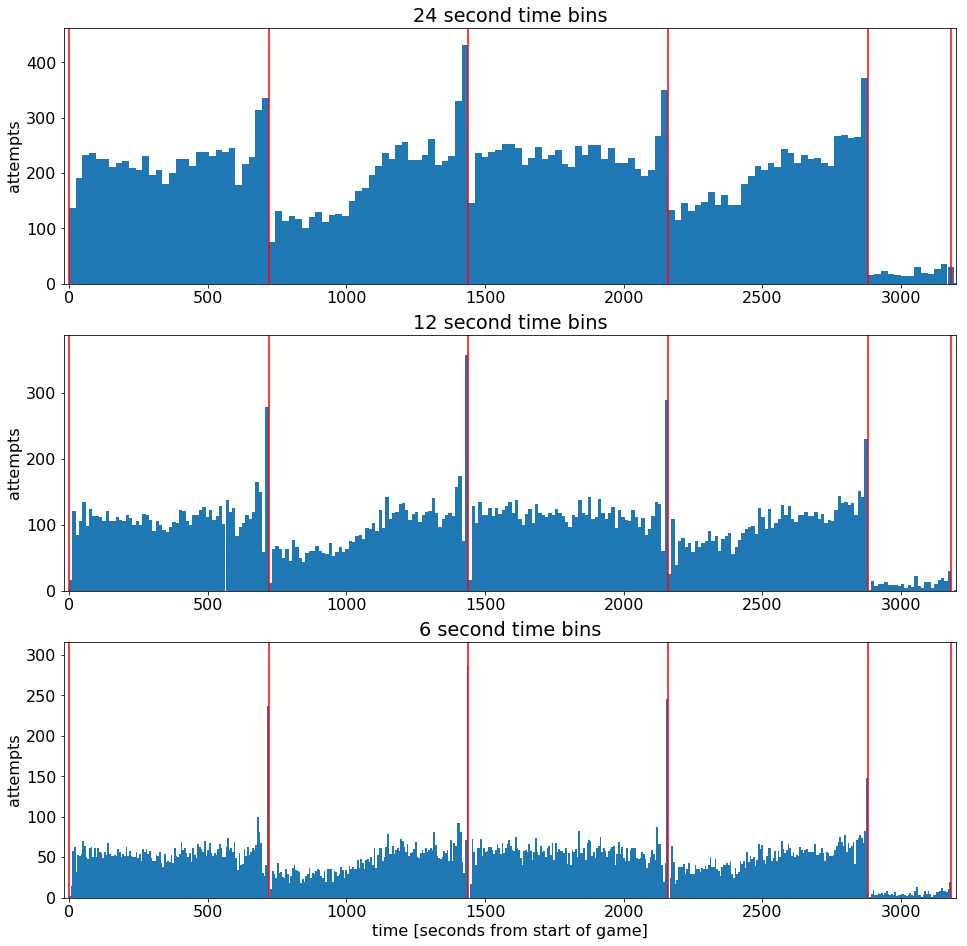

In [32]:
# plot the shot attempts as a function of time (from start of game) with several different binnings
plt.rcParams['figure.figsize'] = (16, 16)
plt.rcParams['font.size'] = 16
binsSizes = [24,12,6]

plt.figure()

for k, binSizeInSeconds in enumerate(binsSizes):
    # assume that there is 3 overtime
    timeBins = np.arange(0,60*(4*12+3*5),binSizeInSeconds)+0.01
    # to find out the data in which second bins
    attemptsAsFunctionOfTime, b = np.histogram(data['secondsFromGameStart'], bins=timeBins)     
    maxHeight = max(attemptsAsFunctionOfTime) + 30
    barWidth = 0.999*(timeBins[1]-timeBins[0])
    plt.subplot(len(binsSizes),1,k+1); 
    plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth); plt.title(str(binSizeInSeconds) + ' second time bins')
    plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight, colors='r')
    plt.xlim((-20,3200)); plt.ylim((0,maxHeight)); plt.ylabel('attempts')
plt.xlabel('time [seconds from start of game]')
plt.show()

# Plot Shot Accuracy as function of time during the game

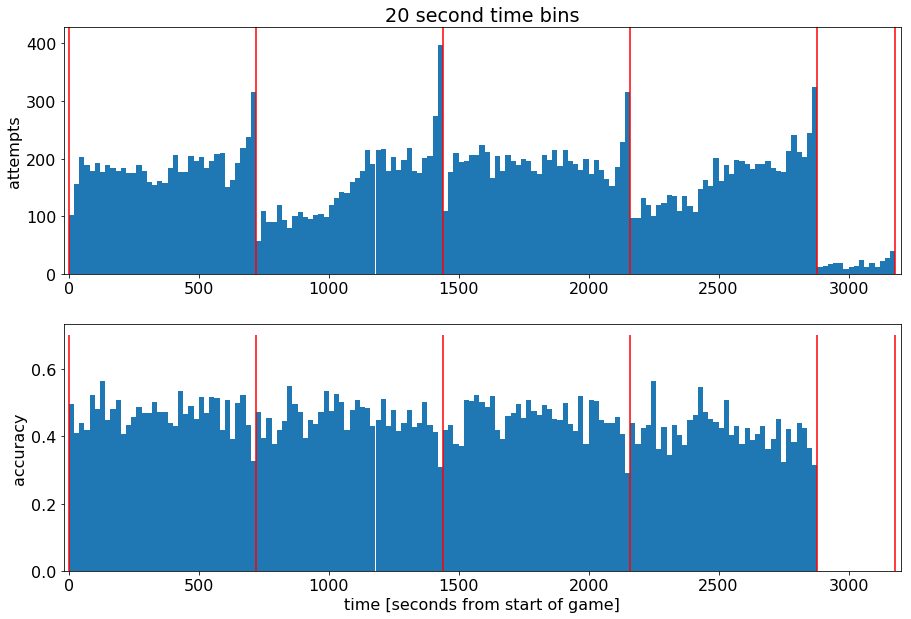

In [38]:
#%% plot the accuracy as a function of time
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 16

binSizeInSeconds = 20
timeBins = np.arange(0,60*(4*12+3*5),binSizeInSeconds)+0.01
attemptsAsFunctionOfTime,     b = np.histogram(data['secondsFromGameStart'], bins=timeBins)     
# to find out the sucessive shot by second
madeAttemptsAsFunctionOfTime, b = np.histogram(data.loc[data['shot_made_flag']==1,'secondsFromGameStart'], bins=timeBins)
attemptsAsFunctionOfTime[attemptsAsFunctionOfTime < 1] = 1
# get the accuracy by second
accuracyAsFunctionOfTime = madeAttemptsAsFunctionOfTime.astype(float)/attemptsAsFunctionOfTime
accuracyAsFunctionOfTime[attemptsAsFunctionOfTime <= 50] = 0 # zero accuracy in bins that don't have enough samples

maxHeight = max(attemptsAsFunctionOfTime) + 30
barWidth = 0.999*(timeBins[1]-timeBins[0])

plt.figure();
plt.subplot(2,1,1); plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth); 
plt.xlim((-20,3200)); plt.ylim((0,maxHeight)); plt.ylabel('attempts'); plt.title(str(binSizeInSeconds) + ' second time bins')
plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight, colors='r')
plt.subplot(2,1,2); plt.bar(timeBins[:-1],accuracyAsFunctionOfTime, align='edge', width=barWidth); 
plt.xlim((-20,3200)); plt.ylabel('accuracy'); plt.xlabel('time [seconds from start of game]')
plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0.0,ymax=0.7, colors='r')
plt.show()

# Now let's continue our initial exploration and examine the spatial location aspect of kobe's shots
### we'll do this by building a gaussian mixture model that tries to summerize Kobe's shot locations compactly

In [39]:
#%% cluster the shot attempts of kobe using GMM on their location
numGaussians = 13
gaussianMixtureModel = mixture.GaussianMixture(n_components=numGaussians, covariance_type='full', 
                                               init_params='kmeans', n_init=50, 
                                               verbose=0, random_state=5)
gaussianMixtureModel.fit(data.loc[:,['loc_x','loc_y']])

# add the GMM cluster as a field in the dataset
data['shotLocationCluster'] = gaussianMixtureModel.predict(data.loc[:,['loc_x','loc_y']])

In [40]:
#%% define draw functions (stealing shamelessly the draw_court() function from MichaelKrueger's excelent script)

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

def Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages):
    
    fig, h = plt.subplots();
    for i, (mean, covarianceMatrix) in enumerate(zip(gaussianMixtureModel.means_, gaussianMixtureModel.covariances_)):
        # get the eigen vectors and eigen values of the covariance matrix
        v, w = np.linalg.eigh(covarianceMatrix)
        v = 2.5*np.sqrt(v) # go to units of standard deviation instead of variance
        
        # calculate the ellipse angle and two axis length and draw it
        u = w[0] / np.linalg.norm(w[0])    
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        currEllipse = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=ellipseColors[i])
        currEllipse.set_alpha(0.5)
        h.add_artist(currEllipse)
        h.text(mean[0]+7, mean[1]-1, ellipseTextMessages[i], fontsize=13, color='blue')

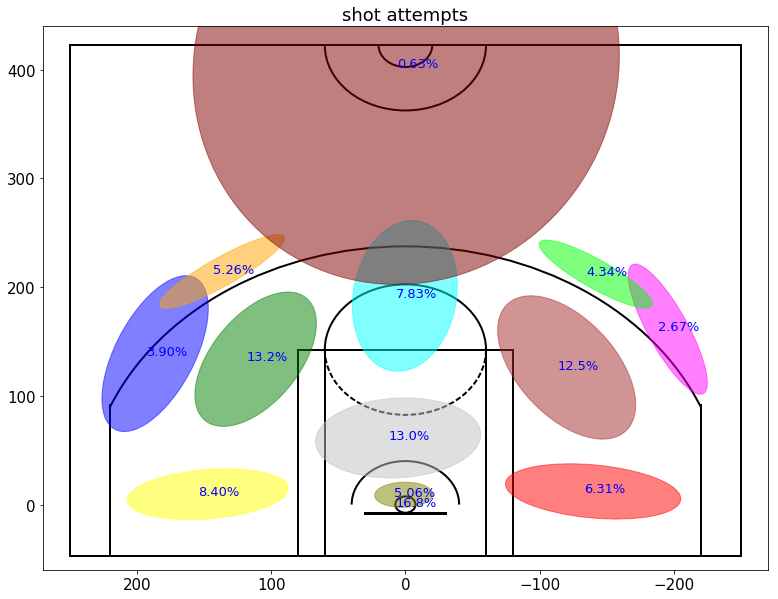

In [41]:
#%% show gaussian mixture elipses of shot attempts
plt.rcParams['figure.figsize'] = (13, 10)
plt.rcParams['font.size'] = 15

ellipseTextMessages = [str(100*gaussianMixtureModel.weights_[x])[:4]+'%' for x in range(numGaussians)]
ellipseColors = ['red','green','purple','cyan','magenta','yellow','blue','orange','silver','maroon','lime','olive','brown','darkblue']
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('shot attempts')
plt.show()